Error: Failed to fetch data for binancecoin. Status code: 429
Error: Failed to fetch data for dogecoin. Status code: 429
Error: Failed to fetch data for usd-coin. Status code: 429
Error: Failed to fetch data for cardano. Status code: 429
Error: Failed to fetch data for staked-ether. Status code: 429
Error: Failed to fetch data for tron. Status code: 429
Error: Failed to fetch data for avalanche-2. Status code: 429
Error: Failed to fetch data for chainlink. Status code: 429
Error: Failed to fetch data for shiba-inu. Status code: 429
Error: Failed to fetch data for wrapped-steth. Status code: 429
Error: Failed to fetch data for the-open-network. Status code: 429
Error: Failed to fetch data for sui. Status code: 429
Error: Failed to fetch data for polkadot. Status code: 429
Error: Failed to fetch data for wrapped-bitcoin. Status code: 429
Error: Failed to fetch data for stellar. Status code: 429
Error: Failed to fetch data for hedera-hashgraph. Status code: 429
Error: Failed to fetch data

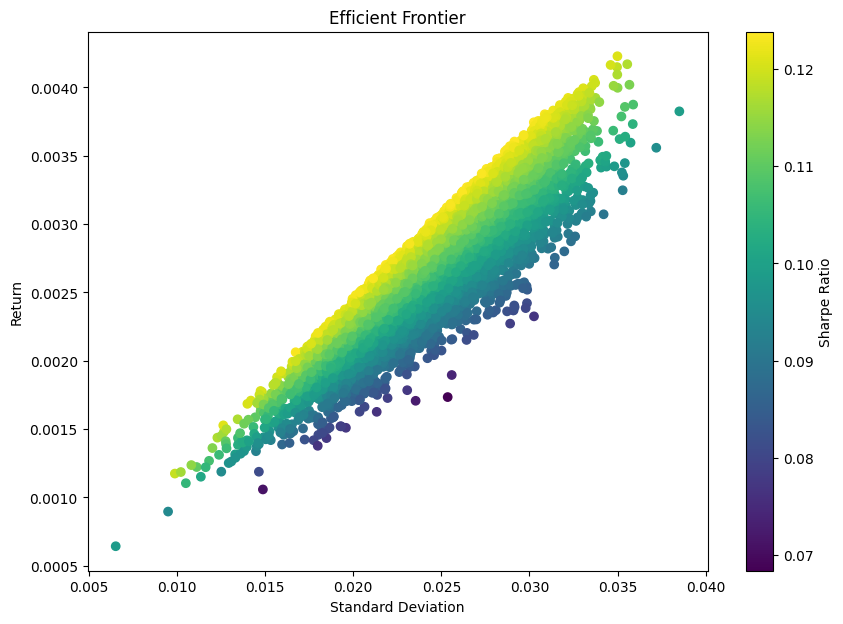

In [3]:
import pandas as pd
import numpy as np
import requests
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Function to get top 30 cryptocurrencies by market cap
def get_top_30():
    url = 'https://api.coingecko.com/api/v3/coins/markets'
    params = {'vs_currency': 'usd', 'order': 'market_cap_desc', 'per_page': 30, 'page': 1}
    response = requests.get(url, params=params)
    
    if response.status_code != 200:
        print(f"Error: Failed to fetch data. Status code: {response.status_code}")
        return []
    
    try:
        data = response.json()
        if isinstance(data, list):
            return [coin['id'] for coin in data if 'id' in coin]
        else:
            print("Error: Unexpected data format received from API.")
            return []
    except ValueError:
        print("Error: Response content is not valid JSON.")
        return []

# Function to get historical market data
def get_historical_data(coin_id, days=365):
    url = f'https://api.coingecko.com/api/v3/coins/{coin_id}/market_chart'
    params = {'vs_currency': 'usd', 'days': days}
    response = requests.get(url, params=params)
    
    if response.status_code != 200:
        print(f"Error: Failed to fetch data for {coin_id}. Status code: {response.status_code}")
        return pd.DataFrame()
    
    try:
        data = response.json()
        if 'prices' in data:
            prices = data['prices']
            df = pd.DataFrame(prices, columns=['timestamp', coin_id])
            df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
            df.set_index('timestamp', inplace=True)
            return df
        else:
            print(f"Warning: 'prices' not found for {coin_id}. Skipping.")
            return pd.DataFrame()
    except ValueError:
        print(f"Error: Response content for {coin_id} is not valid JSON.")
        return pd.DataFrame()

# Get top 30 coins
top_30 = get_top_30()
if not top_30:
    print("No coins fetched. Exiting.")
    exit()

# Retrieve and merge data
price_data = pd.DataFrame()
for coin in top_30:
    df = get_historical_data(coin)
    if not df.empty:
        price_data = pd.concat([price_data, df[coin]], axis=1)

if price_data.empty:
    print("No price data available. Exiting.")
    exit()

price_data.dropna(inplace=True)

# Calculate daily returns
returns = price_data.pct_change().dropna()

# Calculate mean returns and covariance matrix
mean_returns = returns.mean()
cov_matrix = returns.cov()

# Portfolio optimization
def portfolio_optimization(mean_returns, cov_matrix, num_portfolios=10000):
    results = []
    for _ in range(num_portfolios):
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)
        portfolio_return = np.sum(mean_returns * weights)
        portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        results.append((portfolio_return, portfolio_std))
    return results

portfolio_results = portfolio_optimization(mean_returns, cov_matrix)

# Convert results to DataFrame
df_results = pd.DataFrame(portfolio_results, columns=['Return', 'StdDev'])

# Plot efficient frontier
plt.figure(figsize=(10, 7))
plt.scatter(df_results['StdDev'], df_results['Return'], c=df_results['Return']/df_results['StdDev'], marker='o')
plt.xlabel('Standard Deviation')
plt.ylabel('Return')
plt.title('Efficient Frontier')
plt.colorbar(label='Sharpe Ratio')
plt.show()

In [4]:
import pandas as pd
import numpy as np
import requests
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import time

# Function to get top 30 cryptocurrencies by market cap
def get_top_30():
    url = 'https://api.coingecko.com/api/v3/coins/markets'
    params = {'vs_currency': 'usd', 'order': 'market_cap_desc', 'per_page': 30, 'page': 1}
    response = requests.get(url, params=params)
    
    if response.status_code != 200:
        print(f"Error: Failed to fetch data. Status code: {response.status_code}")
        return []
    
    try:
        data = response.json()
        if isinstance(data, list):
            return [coin['id'] for coin in data if 'id' in coin]
        else:
            print("Error: Unexpected data format received from API.")
            return []
    except ValueError:
        print("Error: Response content is not valid JSON.")
        return []

# Function to get historical market data with retry mechanism
def get_historical_data(coin_id, days=365, retries=5, backoff_factor=1):
    url = f'https://api.coingecko.com/api/v3/coins/{coin_id}/market_chart'
    params = {'vs_currency': 'usd', 'days': days}
    
    for attempt in range(retries):
        response = requests.get(url, params=params)
        
        if response.status_code == 200:
            try:
                data = response.json()
                if 'prices' in data:
                    prices = data['prices']
                    df = pd.DataFrame(prices, columns=['timestamp', coin_id])
                    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
                    df.set_index('timestamp', inplace=True)
                    return df
                else:
                    print(f"Warning: 'prices' not found for {coin_id}. Skipping.")
                    return pd.DataFrame()
            except ValueError:
                print(f"Error: Invalid JSON for {coin_id}.")
                return pd.DataFrame()
        elif response.status_code == 429:
            wait = backoff_factor * (2 ** attempt)
            print(f"Rate limit exceeded. Retrying in {wait} seconds...")
            time.sleep(wait)
        else:
            print(f"Error: Failed to fetch data for {coin_id}. Status code: {response.status_code}")
            return pd.DataFrame()
    
    print(f"Failed to fetch data for {coin_id} after {retries} attempts.")
    return pd.DataFrame()

# Get top 30 coins
top_30 = get_top_30()
if not top_30:
    print("No coins fetched. Exiting.")
    exit()

# Retrieve and merge data
price_data = pd.DataFrame()
for coin in top_30:
    df = get_historical_data(coin)
    if not df.empty:
        price_data = pd.concat([price_data, df[coin]], axis=1)
    time.sleep(1)  # Delay to prevent hitting rate limits

if price_data.empty:
    print("No price data available. Exiting.")
    exit()

price_data.dropna(inplace=True)

# Calculate daily returns
returns = price_data.pct_change().dropna()

# Calculate mean returns and covariance matrix
mean_returns = returns.mean()
cov_matrix = returns.cov()

# Portfolio optimization to maximize return for $1000 investment
def portfolio_optimization(mean_returns, cov_matrix, num_portfolios=10000):
    results = []
    for _ in range(num_portfolios):
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)
        portfolio_return = np.sum(mean_returns * weights)
        portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        results.append((portfolio_return, portfolio_std, weights))
    return results

portfolio_results = portfolio_optimization(mean_returns, cov_matrix)

# Convert results to DataFrame
df_results = pd.DataFrame(portfolio_results, columns=['Return', 'StdDev', 'Weights'])

# Plot efficient frontier
plt.figure(figsize=(10, 7))
scatter = plt.scatter(df_results['StdDev'], df_results['Return'], c=df_results['Return']/df_results['StdDev'], marker='o')
plt.xlabel('Standard Deviation')
plt.ylabel('Return')
plt.title('Efficient Frontier')
plt.colorbar(scatter, label='Sharpe Ratio')
plt.show()

Rate limit exceeded. Retrying in 1 seconds...
Rate limit exceeded. Retrying in 2 seconds...
Rate limit exceeded. Retrying in 4 seconds...
Rate limit exceeded. Retrying in 8 seconds...
Rate limit exceeded. Retrying in 16 seconds...
Failed to fetch data for tether after 5 attempts.
Rate limit exceeded. Retrying in 1 seconds...
Rate limit exceeded. Retrying in 2 seconds...
Rate limit exceeded. Retrying in 4 seconds...
Rate limit exceeded. Retrying in 8 seconds...


KeyboardInterrupt: 